In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [9]:
feature_extractor = 'orb'
feature_matching = 'bf'

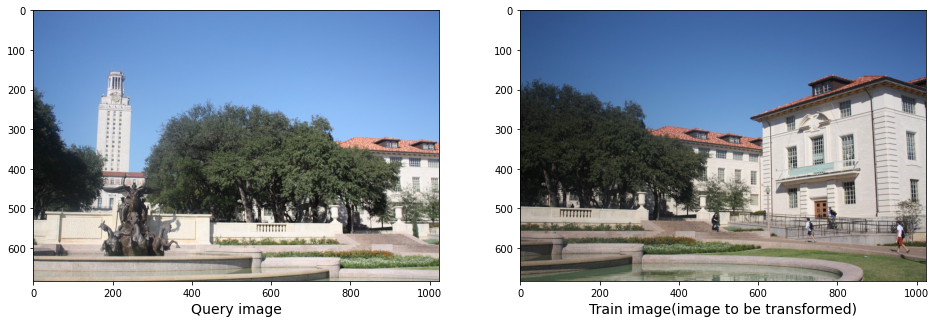

In [10]:
trainIMG=imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
trainIMG_gray = cv2.cvtColor(trainIMG,cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')
queryImg_gray = cv2.cvtColor(queryImg,cv2.COLOR_RGB2GRAY)

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(16,9))
ax1.imshow(queryImg,cmap='gray')
ax1.set_xlabel("Query image",fontsize=14)

ax2.imshow(trainIMG,cmap='gray')
ax2.set_xlabel("Train image(image to be transformed)",fontsize=14)

plt.show()

In [11]:
def detectAndDescribe(image,method=None):
    assert method is not None
    
    if method=='sift':
        descriptor=cv2.xfeatures2d.SIFT_create()
    elif method=='surf':
        descriptor=cv2.xfeatures2d.SURF_create()
    elif method=='brisk':
        descriptor=cv2.BRISK_create()
    elif method=='orb':
        descriptor=cv2.ORB_create()
    (kps,features) = descriptor.detectAndCompute(image,None)
    
    return (kps,features)

In [12]:
kspA,featuresA = detectAndDescribe(trainIMG_gray,method=feature_extractor)
kspB,featuresB = detectAndDescribe(queryImg_gray,method=feature_extractor)

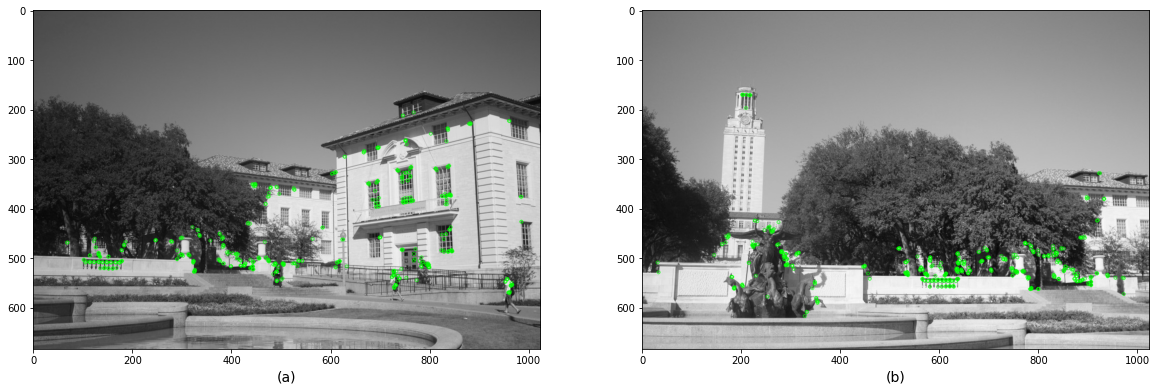

In [15]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,8),constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainIMG_gray,kspA,None,color=(0,255,0)))
ax1.set_xlabel("(a)",fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kspB,None,color=(0,255,0)))
ax2.set_xlabel("(b)",fontsize=14)

plt.show()

In [16]:
def createMatcher(method,crossCheck):
    if method=='sit' or method=='surf':
        bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=crossCheck)
    elif method=='orb' or method=='brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck==crossCheck)
    return bf


In [18]:
def matchKeyPointsBF(featuresA,featuresB,method):
    bf = createMatcher(method,crossCheck=True)
    
    best_matches = bf.match(featuresA,featuresB)
    
    rawMatches = sorted(best_matches,key=lambda x:x.distance)
    print('Raw matches(Brute force):',len(rawMatches))
    return rawMatches

In [19]:
def matchKeyPointsKNN(featuresA,featuresB,ratio,method):
    bf = createMatcher(method,crossCheck=False)
    
    rawMatches = bf.knnMatch(featuresA,featuresB,2)
    print("Raw matches(knn):",len(rawMatches))
    matches = []
    
    for m,n in rawMatches:
        if m.distance<n.distance*ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches(Brute force): 185


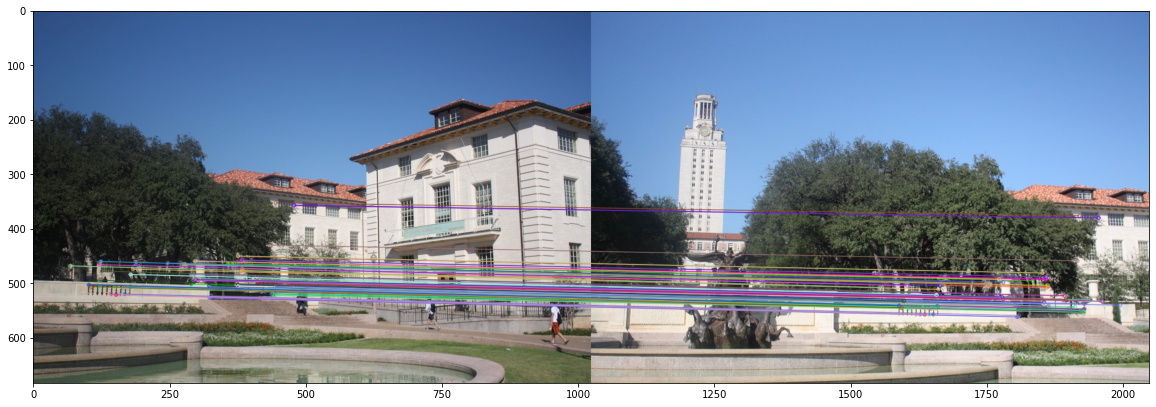

In [21]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching =='bf':
    matches= matchKeyPointsBF(featuresA,featuresB,method=feature_extractor)
    img3 = cv2.drawMatches(trainIMG,kspA,queryImg,kspB,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

elif feature_matching=='knn':
    matches = matchKeyPointsKNN(featuresA,featuresB,ratio=0.75,method=feature_extractor)
    img3 = cv2.drawMatches(trainIMG,kspA,queryImg,kspB,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
plt.imshow(img3)
plt.show()

In [22]:
def getHomography(kspA,kspB,featuresA,featuresB,matches,reprojThresh):
    kspA = np.float32([kp.pt for kp in kspA])
    kspB = np.float32([kp.pt for kp in kspB])
    
    if len(matches)>4:
        
        ptsA = np.float32([kspA[m.queryIdx] for m in matches])
        ptsB = np.float32([kspB[m.trainIdx] for m in matches])
        
        (H,status) = cv2.findHomography(ptsA,ptsB,cv2.RANSAC,reprojThresh)
        
        return (matches,H,status)
    else:
        return None

In [23]:
M = getHomography(kspA,kspB,featuresA,featuresB,matches,reprojThresh=4)
if M is None:
    print('Error!')
(matches,H,status) = M
print(H)

[[ 7.92272362e-01  8.22117652e-02  4.34671442e+02]
 [-1.33501977e-01  9.58413827e-01  6.55962640e+01]
 [-2.09248580e-04  1.60937718e-05  1.00000000e+00]]


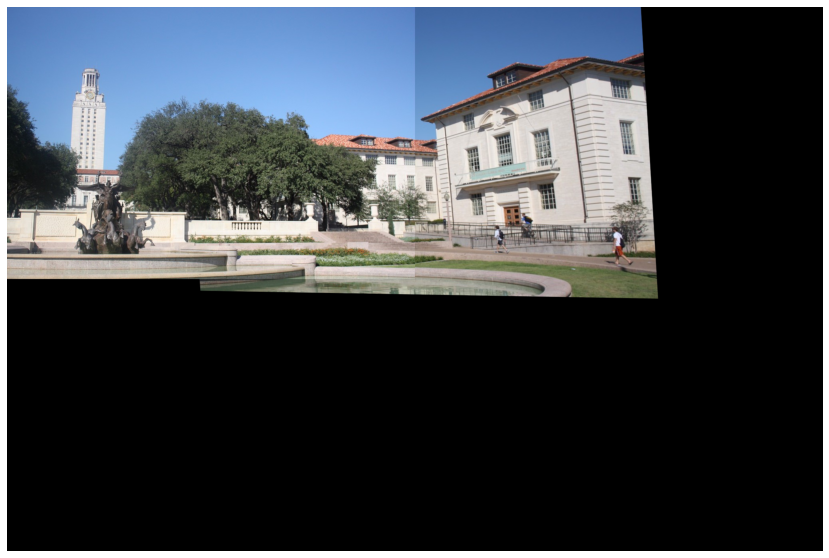

In [26]:
width = trainIMG.shape[1] + queryImg.shape[1]
height = trainIMG.shape[0]+queryImg.shape[0]

result = cv2.warpPerspective(trainIMG,H,(width,height))
result[0:queryImg.shape[0],0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

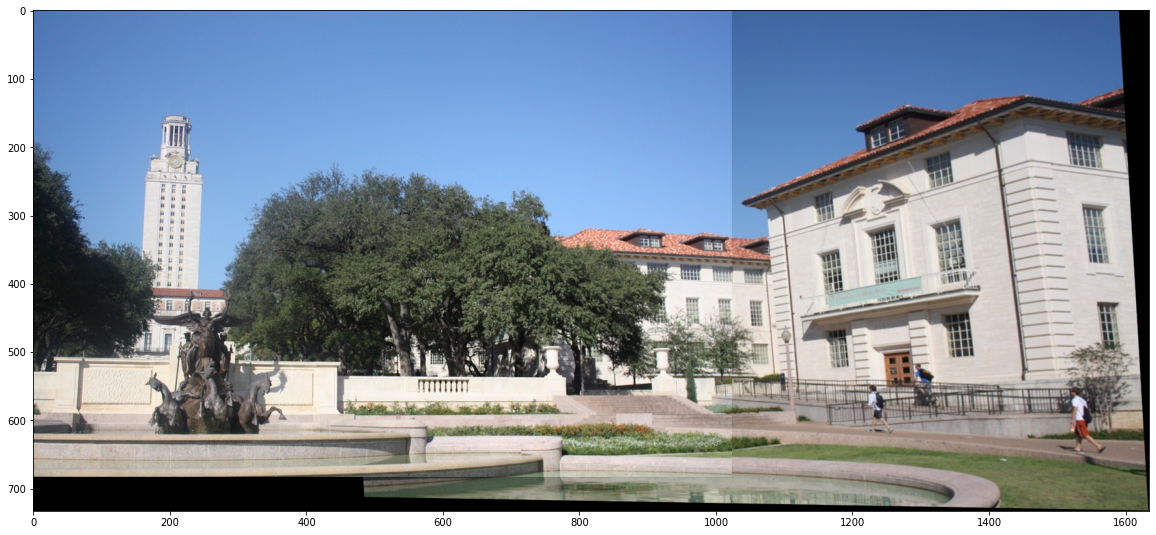

In [27]:
gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c = max(cnts,key=cv2.contourArea)

(x,y,w,h) = cv2.boundingRect(c)

result = result[y:y+h,x:x+w]

plt.figure(figsize=(20,10))
plt.imshow(result)